**Load the model from HuggingFace**

In [1]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
import torch
from datasets import load_dataset
from pprint import pprint

/home/farzad_rzt/python_env/llava-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**<span style="color:orange">Load the model</span>**

- **<span style="color:yellow">Quantized model: Requires near `8` GB of GPU memory with the configuration provided in the cell below.</span>**
- **<span style="color:yellow">Full model: Requires near `24` GB of GPU for inferencing</span>**

In [2]:
MODEL_ID = "llava-hf/llava-v1.6-mistral-7b-hf"
REPO_ID = "Farzad-R/llava-v1.6-mistral-7b-cordv2"

In [3]:
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
# Load the base model with adapters on top
model = LlavaNextForConditionalGeneration.from_pretrained(
    REPO_ID,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


**<span style="color:orange">Function for converting the model output to a nicely formatted JSON</span>**

In [4]:
# let's turn that into JSON
import re
def token2json(tokens, is_inner_value=False, added_vocab=None):
        """
        Convert a (generated) token sequence into an ordered JSON format.
        """
        if added_vocab is None:
            added_vocab = processor.tokenizer.get_added_vocab()

        output = {}

        while tokens:
            start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
            if start_token is None:
                break
            key = start_token.group(1)
            key_escaped = re.escape(key)

            end_token = re.search(rf"</s_{key_escaped}>", tokens, re.IGNORECASE)
            start_token = start_token.group()
            if end_token is None:
                tokens = tokens.replace(start_token, "")
            else:
                end_token = end_token.group()
                start_token_escaped = re.escape(start_token)
                end_token_escaped = re.escape(end_token)
                content = re.search(
                    f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE | re.DOTALL
                )
                if content is not None:
                    content = content.group(1).strip()
                    if r"<s_" in content and r"</s_" in content:  # non-leaf node
                        value = token2json(content, is_inner_value=True, added_vocab=added_vocab)
                        if value:
                            if len(value) == 1:
                                value = value[0]
                            output[key] = value
                    else:  # leaf nodes
                        output[key] = []
                        for leaf in content.split(r"<sep/>"):
                            leaf = leaf.strip()
                            if leaf in added_vocab and leaf[0] == "<" and leaf[-2:] == "/>":
                                leaf = leaf[1:-2]  # for categorical special tokens
                            output[key].append(leaf)
                        if len(output[key]) == 1:
                            output[key] = output[key][0]

                tokens = tokens[tokens.find(end_token) + len(end_token) :].strip()
                if tokens[:6] == r"<sep/>":  # non-leaf nodes
                    return [output] + token2json(tokens[6:], is_inner_value=True, added_vocab=added_vocab)

        if len(output):
            return [output] if is_inner_value else output
        else:
            return [] if is_inner_value else {"text_sequence": tokens}

**<span style="color:orange">Load the validation dataset</span>**

In [5]:
dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

**<span style="color:yellow">Example 1</span>**

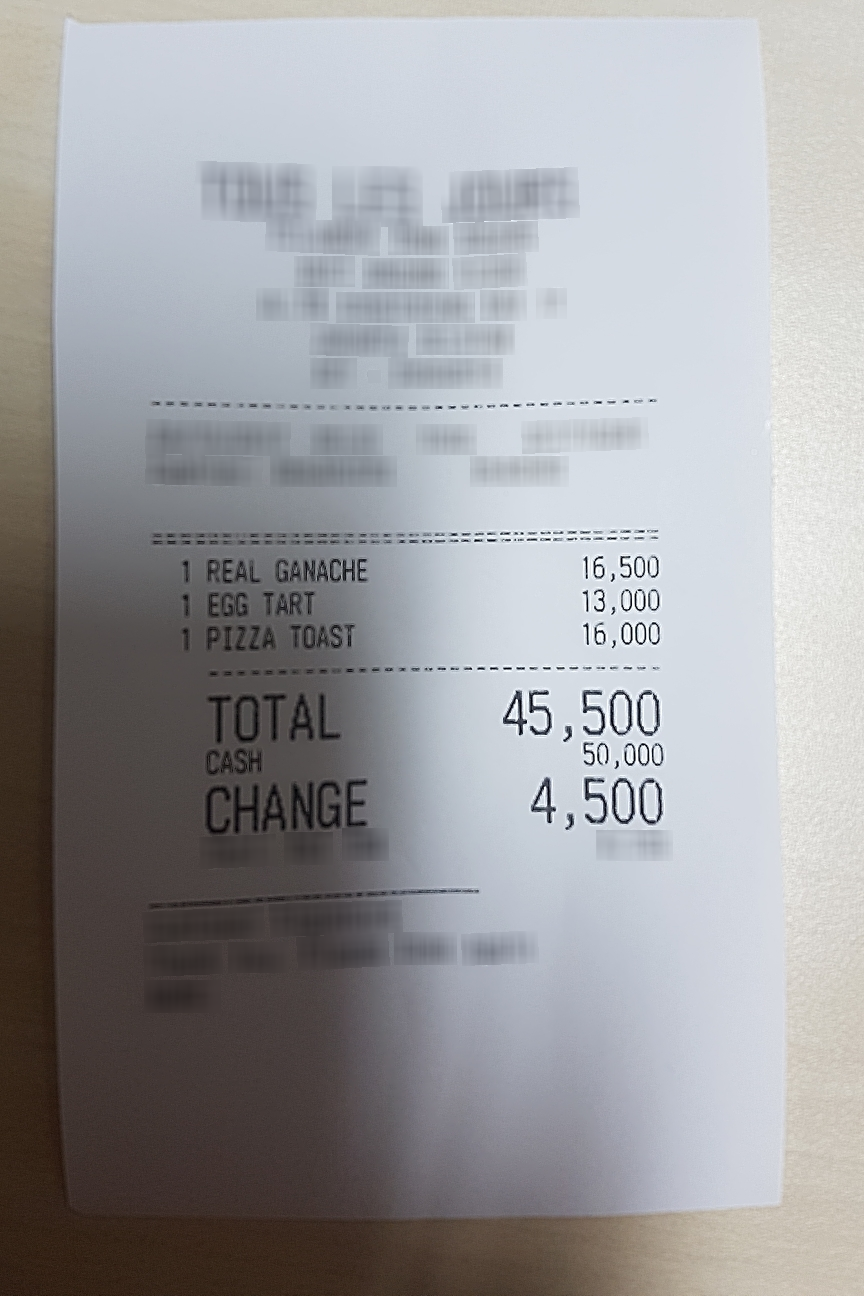

In [6]:
image = dataset[0]["image"]
image

In [7]:
prompt = f"[INST] <image>\nExtract JSON [/INST]"
max_output_token = 256
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
output = model.generate(**inputs, max_new_tokens=max_output_token)
response = processor.decode(output[0], skip_special_tokens=True)
response

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


'[INST]  \nExtract JSON [/INST] <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total> '

**<span style="color:pink">Model's output vs the ground truth</span>**

In [8]:
import json

generated_json = token2json(response)
print("Expected response:\n") 
pprint(json.loads(dataset[0]["ground_truth"])["gt_parse"])
print()
print("Converting model's output to JSON:\n")
pprint(generated_json)

Expected response:

{'menu': [{'cnt': '1', 'nm': 'REAL GANACHE', 'price': '16,500'},
          {'cnt': '1', 'nm': 'EGG TART', 'price': '13,000'},
          {'cnt': '1', 'nm': 'PIZZA TOAST', 'price': '16,000'}],
 'total': {'cashprice': '50,000',
           'changeprice': '4,500',
           'total_price': '45,500'}}

Converting model's output to JSON:

{'menu': [{'cnt': '1', 'nm': 'REAL GANACHE', 'price': '16,500'},
          {'cnt': '1', 'nm': 'EGG TART', 'price': '13,000'},
          {'cnt': '1', 'nm': 'PIZZA TOAST', 'price': '16,000'}],
 'total': {'cashprice': '50,000',
           'changeprice': '4,500',
           'total_price': '45,500'}}


**<span style="color:yellow">Example 2</span>**

In [9]:
image = dataset[1]["image"]
prompt = f"[INST] <image>\nExtract JSON [/INST]"
max_output_token = 256
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
output = model.generate(**inputs, max_new_tokens=max_output_token)
response = processor.decode(output[0], skip_special_tokens=True)
response

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'[INST]  \nExtract JSON [/INST] <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total> '

**<span style="color:pink">Model's output vs the ground truth</span>**

In [10]:
generated_json = token2json(response)
print("Expected response:\n") 
pprint(json.loads(dataset[1]["ground_truth"])["gt_parse"])
print()
print("Converting model's output to JSON:\n")
pprint(generated_json)

Expected response:

{'menu': {'cnt': '1', 'nm': 'Kopi Susu Kolonel', 'price': '23.000'},
 'total': {'cashprice': '50.000',
           'changeprice': '27.000',
           'total_price': '23.000'}}

Converting model's output to JSON:

{'menu': {'cnt': '1', 'nm': 'Kopi Susu Kolonel', 'price': '23.000'},
 'total': {'cashprice': '50.000',
           'changeprice': '27.000',
           'total_price': '23.000'}}


**<span style="color:yellow">Example 3</span>**

In [11]:
image = dataset[10]["image"]
prompt = f"[INST] <image>\nExtract JSON [/INST]"
max_output_token = 256
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
output = model.generate(**inputs, max_new_tokens=max_output_token)
response = processor.decode(output[0], skip_special_tokens=True)
response

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'[INST]  \nExtract JSON [/INST] <s_menu><s_nm>Serbu 1</s_nm><s_cnt>2</s_cnt><s_price>40.000</s_price><sep/><s_nm>Choco Peanut Bread</s_nm><s_cnt>2</s_cnt><s_price>20.000</s_price></s_menu><s_total><s_total_price>60.000</s_total_price><s_cashprice>60.000</s_cashprice><s_changeprice>0</s_changeprice></s_total> '

**<span style="color:pink">Model's output vs the ground truth</span>**

In [12]:
generated_json = token2json(response)
print("Expected response:\n") 
pprint(json.loads(dataset[10]["ground_truth"])["gt_parse"])
print()
print("Converting model's output to JSON:\n")
pprint(generated_json)

Expected response:

{'menu': [{'cnt': '2', 'nm': 'Serbu 1', 'price': '40.000'},
          {'cnt': '2', 'nm': 'Choco Peanut Bread', 'price': '20.000'}],
 'total': {'cashprice': '60.000', 'changeprice': '0', 'total_price': '60.000'}}

Converting model's output to JSON:

{'menu': [{'cnt': '2', 'nm': 'Serbu 1', 'price': '40.000'},
          {'cnt': '2', 'nm': 'Choco Peanut Bread', 'price': '20.000'}],
 'total': {'cashprice': '60.000', 'changeprice': '0', 'total_price': '60.000'}}
